In [26]:
# Mengimpor beberapa library dan modul yang diperlukan dalam project ini

import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.python.keras import layers, Model
import keras.utils as image
import pathlib
import ibm_boto3
from ibm_botocore.client import Config, ClientError
import io

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"gededhio","key":"43245a3d1019776c9e477ce09e9a5ffa"}

import json

with open('/home/wsuser/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /home/wsuser/.kaggle/kaggle.json

In [4]:
!pip install kaggle
import kaggle
!kaggle datasets download -d gededhio/bungaaa --unzip gededhio/bungaaa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 16.4 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77734 sha256=64dfc414f66ccedc8db03db9ffe60e9864ef14c3d7bd19d7b9d210da6f48f48f
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/f3/16/ff/34e7d368370d4fd68bb749a59f1d2639ed66f3c14358e340a1
Successfully built kaggle
 98%|███████████████████████████████████████▉ | 217M/222M [00:02<00:00, 108MB/s]
100%|████████████████████████████████████████| 222M/222M [00:02<00:00, 87.4MB/s]


In [5]:
# Menghubungkan dan mengaitkan Google Drive dengan Colab Notebook

#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
# Mengatur jalur direktori dari dataset yang akan digunakan

data_dir = pathlib.Path('./Capstone_Ibm/flower-classification/flower_photos')
test_path=os.path.join(data_dir ,'test')
train_path=os.path.join(data_dir, 'train')
val_path=os.path.join(data_dir, 'validation')

In [7]:
# Menghitung jumlah gambar yang tersedia dalam setiap subset dataset

print("Total number of images: ",len(list(data_dir.glob('*/*/*.jpg')))) #total number of files
print("Images available for training: ",len(list(data_dir.glob('train/*/*.jpg')))) # Number of images for training
print("Images available for test: ",len(list(data_dir.glob('test/*/*.jpg')))) # number of images for test
print("Images available for validation: ",len(list(data_dir.glob('validation/*/*.jpg')))) # Number of images for validation

Total number of images:  3670
Images available for training:  3540
Images available for test:  50
Images available for validation:  80


In [8]:
# Menghitung jumlah file dalam setiap label di direktori train

train_path = './Capstone_Ibm/flower-classification/flower_photos/train'

number_label = {}
total_files = 0

# Memeriksa keberadaan direktori
if os.path.isdir(train_path):
    # Menghitung jumlah file dalam setiap label
    for label in os.listdir(train_path):
        label_path = os.path.join(train_path, label)
        if os.path.isdir(label_path):
            counting = len(os.listdir(label_path))
            number_label[label] = counting
            total_files += counting

    # Menampilkan hasil
    print("Jumlah file dalam setiap label:")
    for label, count in number_label.items():
        print(f"{label}: {count}")

    print(f"Total file: {total_files}")
else:
    print(f"Direktori '{train_path}' tidak ditemukan.")

Jumlah file dalam setiap label:
sunflowers: 673
daisy: 607
tulips: 773
roses: 615
dandelion: 872
Total file: 3540


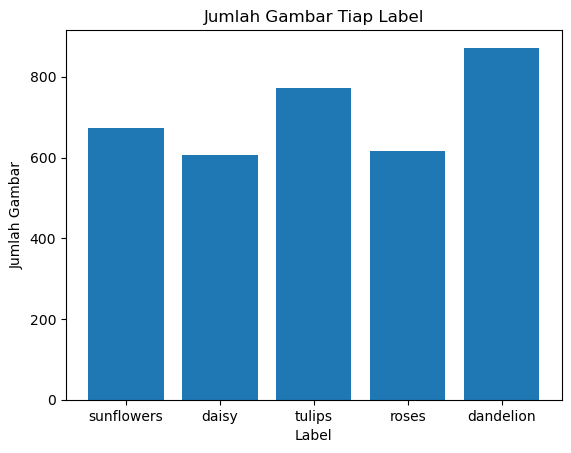

In [9]:
# Membuat diagram bar chart yang menunjukkan jumlah gambar untuk setiap label dalam dataset

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

In [10]:
# Memuat data gambar dari direktori train

train_data= keras.utils.image_dataset_from_directory(train_path,
                                                    seed=123,
                                                    shuffle=True,
                                                    batch_size=32,
                                                    image_size=(180,180)
                                                    )

Found 3540 files belonging to 5 classes.


2023-06-28 16:34:37.397439: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [11]:
# Memuat data gambar dari direktori train

test_data = keras.utils.image_dataset_from_directory(test_path,
                                                    seed=123,
                                                    shuffle=True,
                                                    batch_size=32,
                                                    image_size=(180,180))

Found 50 files belonging to 5 classes.


In [12]:
# Memuat data gambar dari direktori train

val_data= keras.utils.image_dataset_from_directory(val_path,
                                                  seed=123,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(180,180))

Found 80 files belonging to 5 classes.


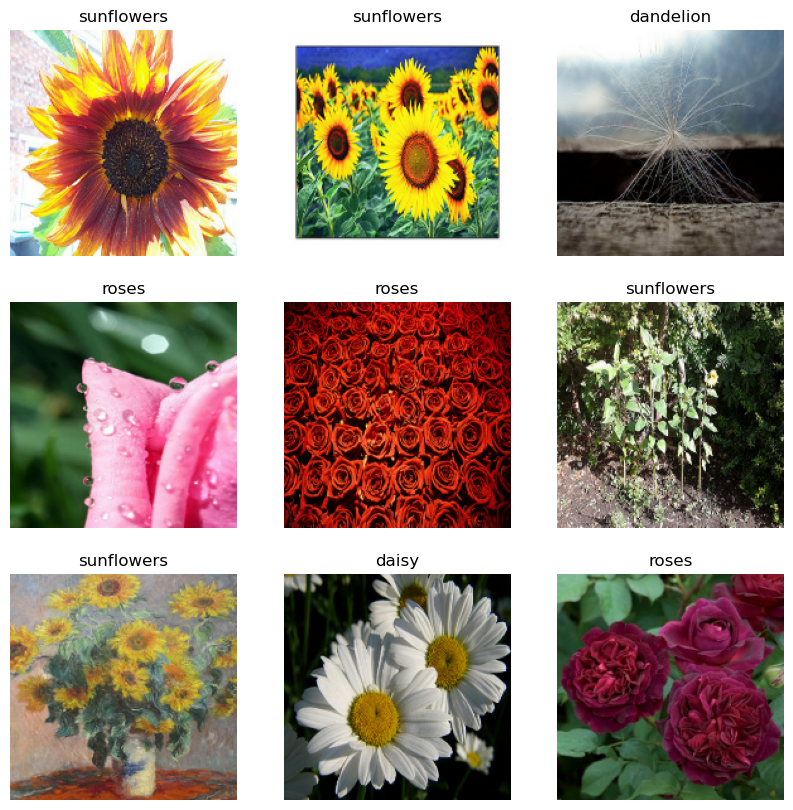

In [13]:
# Menampilkan contoh gambar dari dataset

class_names = train_data.class_names
#print(class_names)
plt.figure(figsize=(10,10))
for images, labels in train_data.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
# Mencetak jumlah batch dalam dataset pelatihan

print("Number of Train batches : %d"%tf.data.experimental.cardinality(train_data))

Number of Train batches : 111


In [15]:
# Melakukan augmentasi data

data_augmentation= keras.Sequential([
     tf.keras.layers.RandomFlip('horizontal'),
     tf.keras.layers.RandomZoom(0.1),
     tf.keras.layers.RandomRotation(0.2),
 ])

In [16]:
# Memeriksa bentuk(shape) batch gambar dan label dalam train_data

for batch, labels in train_data:
    print(batch.shape)
    print(labels.shape)
    break

(32, 180, 180, 3)
(32,)


In [17]:
# Model arsitektur TensorFlow Keras

inputs= keras.Input(shape=(180,180,3))
x= data_augmentation(inputs)
x= tf.keras.layers.Rescaling(1./255)(x)

x=tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x= tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x=tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x=tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x=tf.keras.layers.Flatten()(x)
outputs=tf.keras.layers.Dense(5, activation='sigmoid')(x)

model= keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                             

In [18]:
# Mengkonfigurasi model

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

In [19]:
# Training model
history= model.fit(train_data,
                  epochs=100,
                   validation_data=val_data
                  )

Epoch 1/100


2023-06-28 16:34:59.185556: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-28 16:34:59.187212: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


111/111 [==============================] - 7s 38ms/step - loss: 1.3295 - accuracy: 0.4102 - val_loss: 1.1263 - val_accuracy: 0.5250
Epoch 2/100
111/111 [==============================] - 4s 34ms/step - loss: 1.1165 - accuracy: 0.5573 - val_loss: 0.9358 - val_accuracy: 0.6250
Epoch 3/100
111/111 [==============================] - 4s 34ms/step - loss: 1.0370 - accuracy: 0.5873 - val_loss: 0.9214 - val_accuracy: 0.6625
Epoch 4/100
111/111 [==============================] - 4s 33ms/step - loss: 0.9755 - accuracy: 0.6138 - val_loss: 0.7424 - val_accuracy: 0.7125
Epoch 5/100
111/111 [==============================] - 4s 33ms/step - loss: 0.9097 - accuracy: 0.6353 - val_loss: 0.7410 - val_accuracy: 0.7625
Epoch 6/100
111/111 [==============================] - 4s 34ms/step - loss: 0.8711 - accuracy: 0.6621 - val_loss: 0.6617 - val_accuracy: 0.7750
Epoch 7/100
111/111 [==============================] - 4s 34ms/step - loss: 0.8259 - accuracy: 0.6839 - val_loss: 0.6243 - val_accuracy: 0.7625
Epoc

111/111 [==============================] - 4s 32ms/step - loss: 0.3612 - accuracy: 0.8686 - val_loss: 0.3881 - val_accuracy: 0.8375
Epoch 58/100
111/111 [==============================] - 4s 32ms/step - loss: 0.3673 - accuracy: 0.8624 - val_loss: 0.6606 - val_accuracy: 0.8125
Epoch 59/100
111/111 [==============================] - 4s 32ms/step - loss: 0.3536 - accuracy: 0.8684 - val_loss: 0.4057 - val_accuracy: 0.9125
Epoch 60/100
111/111 [==============================] - 4s 32ms/step - loss: 0.3772 - accuracy: 0.8636 - val_loss: 0.4349 - val_accuracy: 0.8625
Epoch 61/100
111/111 [==============================] - 4s 32ms/step - loss: 0.3270 - accuracy: 0.8751 - val_loss: 0.4195 - val_accuracy: 0.8375
Epoch 62/100
111/111 [==============================] - 4s 33ms/step - loss: 0.3590 - accuracy: 0.8624 - val_loss: 0.3968 - val_accuracy: 0.8750
Epoch 63/100
111/111 [==============================] - 4s 32ms/step - loss: 0.3658 - accuracy: 0.8627 - val_loss: 0.4248 - val_accuracy: 0.862

In [20]:
# Mengevaluasi performa model

model.evaluate(val_data)

3/3 [==============================] - 0s 9ms/step - loss: 0.4598 - accuracy: 0.8500


[0.45977792143821716, 0.8500000238418579]

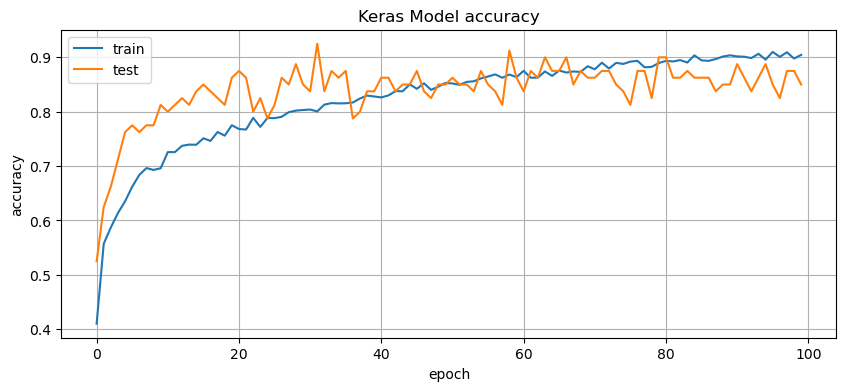

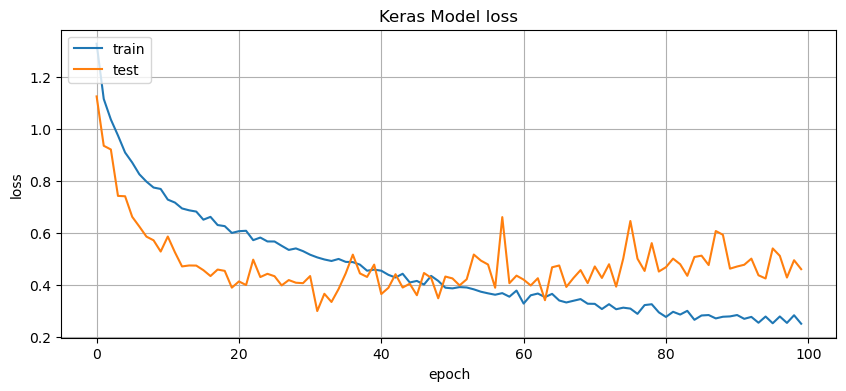

In [21]:
# Membuat plot akurasi model keras
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Keras Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model keras
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 156ms/step
daisy


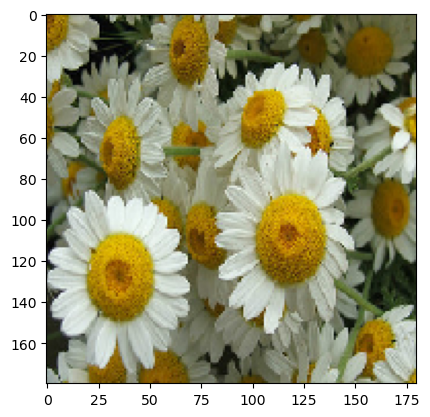

In [22]:
# Menguji model
path = "./Capstone_Ibm/flower-classification/flower_photos/test/daisy/538920244_59899a78f8_n.jpg"
img = image.load_img(path, target_size=(180,180))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=32)
classes = np.argmax(classes)

# print()
if classes==0:
    print('daisy')
elif classes==1:
    print('dandelion')
elif classes==2:
    print('rose')
elif classes==3:
    print('sunflower')
else:
    print('tulip')


In [23]:
model.save('flowers.h5')

In [24]:
# Informasi terkait Cloud Object Storage
cos_credentials={
    "apikey": "DoCGhIOFylpg1nNy9YXpRNDxuDt2KFeoYfoV-HXnGW_M",
    "cos_hmac_keys": {
        "access_key_id": "03b1c760991a409baaac7d80c68bbe46",
        "secret_access_key": "d3dbe9d80b428376eeb896aaa8d8cff49773dc1cf10f67a6"
    },
    "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
    "iam_apikey_description": "Auto-generated for key crn:v1:bluemix:public:cloud-object-storage:global:a/c52277933c9b4d00bced62a17d0c9ca5:d4424470-cf63-4258-9429-b053953a097e:resource-key:03b1c760-991a-409b-aaac-7d80c68bbe46",
    "iam_apikey_name": "WDP-Project-Management-d4424470-cf63-4258-9429-b053953a097e",
    "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Manager",
    "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/c52277933c9b4d00bced62a17d0c9ca5::serviceid:ServiceId-98ee7c1d-310c-40e5-8835-fc412b9ea1fa",
    "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/c52277933c9b4d00bced62a17d0c9ca5:d4424470-cf63-4258-9429-b053953a097e::"
}

auth_endpoint = 'https://iam.cloud.ibm.com/identity/token'
service_endpoint = 'https://s3.private.us-south.cloud-object-storage.appdomain.cloud'

In [27]:
# Buat client
cos = ibm_boto3.client('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                        ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

In [28]:
# Fungsi untuk upload file ke Cloud Object Storage
def upload_file(file_name, bucket, object_name=None):
    if object_name is None:
        object_name = os.path.basename(file_name)
    s3_client = cos
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [29]:
# Upload file model ke Cloud Object Storage
upload_file('./flowers.h5','flowerclassification-donotdelete-pr-osgec9wfegiipm')

True